##  Using Fairlearn to detect gender bias in music recommender system: Spotify Million Dataset

### Content-Based Filtering (CBF) recommender:

**Idea:** Recommend tracks similar to those with high popularity using track features.

**Examples of track features you could use:**
- Genre
- Artist name (or ID)

**How?**
- Create a feature matrix (e.g., one-hot encode genres, artists)
- Use Nearest Neighbor similarity between tracks
- Rank based on similarity to top popular tracks

In [1]:
#import libraries
import pandas as pd

df = pd.read_csv("lastfm_enriched_saved.csv")

#check the data
print(df.head())

   Unnamed: 0 Username          Artist  \
0          30  Babs_05     billy ocean   
1          33  Babs_05   bill callahan   
2          35  Babs_05      rod thomas   
3          36  Babs_05       fela kuti   
4         106  Babs_05  machel montano   

                                               Track  \
0            Lovely Day (feat. YolanDa Brown & Ruti)   
1  Arise, Therefore (feat. Six Organs of Admittance)   
2                                        Old Friends   
3          I.T.T. (International Thief Thief) - Edit   
4                                      Private Party   

                                               Album         Date    Time  \
0            Lovely Day (feat. YolanDa Brown & Ruti)  31 Jan 2021   21:23   
1  Arise, Therefore (feat. Six Organs of Admittance)  31 Jan 2021   21:13   
2                                        Old Friends  31 Jan 2021   21:08   
3          I.T.T. (International Thief Thief) [Edit]  31 Jan 2021   21:01   
4                        

In [2]:
#### Definition of Sensitive/Protected Attribute 
import numpy as np

def map_gender_category(gender):
    gender = str(gender).strip().lower().replace('"', '').replace(";", '').strip()

    if gender == 'male':
        return 'male'
    elif gender == 'female':
        return 'female'
    elif 'non-binary' in gender or 'nonbinary' in gender:
        return 'nonbinary'
    elif any(term in gender for term in ['genderfluid', 'trans', 'agender', 'neutral']):
        return 'other'
    else:
        return 'other'

In [3]:
#Apply gender mapping
df['gender_grouped'] = df['gender'].apply(map_gender_category)
print("Cleaned gender groups:")
print(df['gender_grouped'].value_counts(dropna=False))

Cleaned gender groups:
gender_grouped
male      27720
female    11509
other       227
Name: count, dtype: int64


In [4]:
# Confirm gender groups are clean
print("Remaining gender groups:")
print(df['gender_grouped'].value_counts())

Remaining gender groups:
gender_grouped
male      27720
female    11509
other       227
Name: count, dtype: int64


## Building the Content-Based Recommender using Track, Artist, Album

In [5]:
#Create TF-IDF features for content-based recommender
df['text_features'] = (
    df['Track'].fillna('') + ' ' +
    df['Artist'].fillna('') + ' ' +
    df['Album'].fillna('')
)

df['track_id'] = (df['Artist'] + ' - ' + df['Track']).astype('category').cat.codes

track_df = df.drop_duplicates(subset='track_id').copy()
track_df.reset_index(drop=True, inplace=True)

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(track_df['text_features'])

In [6]:
#Fit NearestNeighbors model
from sklearn.neighbors import NearestNeighbors

nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)

,n_neighbors,5
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [7]:
#Define recommendation function
def recommend_similar_tracks(track_idx, top_n=100):
    distances, indices = nn_model.kneighbors(tfidf_matrix[track_idx], n_neighbors=top_n + 1)
    similar_indices = indices.flatten()[1:]
    return track_df.iloc[similar_indices][['Track', 'Artist', 'Album', 'gender_grouped']]

In [8]:
#Generate recommendations from a seed track
cbf_recs = recommend_similar_tracks(track_idx=0, top_n=100)
recommended_ids = cbf_recs[['Track', 'Artist']].apply(lambda x: f"{x['Artist']} - {x['Track']}", axis=1).tolist()

In [ ]:
#Display recommendations and group distribution - check the recommended tracks
cbf_recs.head(10)  # Show top 10 recommended tracks

cbf_recs['gender_grouped'].value_counts(normalize=True).mul(100).round(2)

gender_grouped
male      78.0
female    22.0
Name: proportion, dtype: float64

In [10]:
#Show seed track and recommendations
seed_track = track_df.iloc[0][['Track', 'Artist', 'Album', 'gender_grouped']]
print("Seed Track:")
print(seed_track)

print("\nTop 10 Recommendations:")
print(cbf_recs.head(10))

Seed Track:
Track             Lovely Day (feat. YolanDa Brown & Ruti)
Artist                                        billy ocean
Album             Lovely Day (feat. YolanDa Brown & Ruti)
gender_grouped                                       male
Name: 0, dtype: object

Top 10 Recommendations:
                               Track            Artist  \
7                         Day by Day        gary bartz   
130                       Lovely Day      bill withers   
8105               Forever And A Day         ian brown   
4798                Olancha Farewell       harold budd   
1052           All the Lovely Ladies  gordon lightfoot   
16863                     Gimme That       chris brown   
8669   Love Really Hurts Without You       billy ocean   
2408                Sweet and Lovely   thelonious monk   
13333                  From This Day       lene marlin   
3372          Lucifer - Instrumental         kev brown   

                                       Album gender_grouped  
7      


#### Interpretation:

The content-based filtering (CBF) recommender produced the following gender distribution in its top 100 recommendations:

- **78%** of the recommended tracks are by **male** artists.
- **22%** are by **female** artists.

This indicates a notable **gender imbalance** in the recommendation output — heavily skewed toward male artists.

#### Seed Track Context:

The seed track used for generating recommendations was:

- **Track**: *Lovely Day (feat. YolanDa Brown & Ruti)*
- **Artist**: *Billy Ocean*
- **Gender Group**: *Male*

The top 10 recommended tracks also primarily feature **male** artists, with only **one track** attributed to a **female** artist (*Lene Marlin*).

#### Key Insight:

This result shows that the CBF recommender, which relies on textual similarity (track, artist, album metadata), tends to recommend artists of the **same gender** as the seed artist. In this case, starting from a male artist resulted in ~78% male-dominated recommendations.

This may suggest:
- The **metadata features** used (e.g., artist/track names) inherently capture stylistic or cultural signals associated with gender.
- The recommender may **amplify existing gender representation imbalances** in the dataset — e.g., if male artists dominate the dataset or certain musical descriptors.

In [11]:
# Select seed tracks by gender group

# Make sure the gender column is clean and used
gender_groups = ['female', 'male', 'nonbinary', 'other']

# Get one seed track index for each gender
seed_indices = {}
for gender in gender_groups:
    match = track_df[track_df['gender_grouped'] == gender].head(1)
    if not match.empty:
        seed_indices[gender] = match.index[0]

print("Seed indices by gender:")
print(seed_indices)


Seed indices by gender:
{'female': 6, 'male': 0, 'other': 303}


In [12]:
#Get recommendations for each gender group
all_cbf_recs = {}

for gender, idx in seed_indices.items():
    recs = recommend_similar_tracks(track_idx=idx, top_n=100)
    recs['seed_gender'] = gender  # track source of seed
    all_cbf_recs[gender] = recs

In [13]:
### Analyze Gender Distribution per Recommendation Set
for gender, recs in all_cbf_recs.items():
    print(f"\n--- Recommendations from {gender} seed ---")
    print(recs['gender_grouped'].value_counts(normalize=True) * 100)


--- Recommendations from female seed ---
gender_grouped
male      72.0
female    28.0
Name: proportion, dtype: float64

--- Recommendations from male seed ---
gender_grouped
male      78.0
female    22.0
Name: proportion, dtype: float64

--- Recommendations from other seed ---
gender_grouped
male      53.0
other     31.0
female    16.0
Name: proportion, dtype: float64


### 🎯 Gender-Specific Seed Track Analysis: CBF Recommendation Behavior

#### Interpretation:

The recommender was tested using **three seed tracks**, each representing a different artist gender group:

| Seed Gender | Index | Description |
|-------------|-------|-------------|
| Female      | 6     | A track by a female artist |
| Male        | 0     | A track by a male artist (Billy Ocean) |
| Other       | 303   | A track by an artist labeled as "other" gender (nonbinary, unknown, etc.) |

The following are the recommendation outcomes for each seed group:

---

####  Recommendations from **female** seed track:
- **72%** male artists
- **28%** female artists

> Despite using a **female** artist as the seed, the majority of recommended tracks were still by **male** artists.

---

#### Recommendations from **male** seed track:
- **78%** male artists
- **22%** female artists

> Similar to the female seed, recommendations heavily favored **male** artists. This mirrors the earlier single-seed results and confirms consistency in skew.

---

#### Recommendations from **'other'** gender seed:
- **53%** male artists
- **31%** artists labeled as **other**
- **16%** female artists

> The 'other' gender seed produced a slightly more **diverse output**, but still leaned male. The model offered the **highest proportion of 'other' gender artists** here (31%), likely due to lexical similarity with niche or independent descriptors shared among 'other' artists.

---

#### Takeaway:

The model exhibits a **consistent male dominance** in its recommendations, **regardless of seed gender**. Even when seeded with underrepresented groups (female or other), the system tends to revert toward recommending male artists.

This suggests:
- A **bias in the underlying dataset** or
- An **inherent reinforcement loop** in content-based systems favoring majority group representations (e.g., more metadata overlap or popularity among male artists).


### Bias Detection using Fairlearn

In [14]:
#install fairlearn
#!pip install fairlearn

In [15]:
#install fairlearn metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    demographic_parity_difference,
    demographic_parity_ratio
)

In [16]:
## Generate recommendations using seed track index 303
cbf_recommendations = recommend_similar_tracks(track_idx=303, top_n=100)

print(cbf_recommendations) 

                 Track                Artist                       Album  \
569     Plastic Hearts           miley cyrus              Plastic Hearts   
633               High           miley cyrus              Plastic Hearts   
632            Hate Me           miley cyrus              Plastic Hearts   
631        Never Be Me           miley cyrus              Plastic Hearts   
1205   Golden G String           miley cyrus              Plastic Hearts   
...                ...                   ...                         ...   
17389      Soul Lament         kenny burrell               Midnight Blue   
16601       Liquid Sky           solar quest                     Orgship   
50            Research              big sean  Dark Sky Paradise (Deluxe)   
7537    Midnight Rider         willie nelson            Walking The Line   
13162  Look To The Sky  antônio carlos jobim                        Wave   

      gender_grouped  
569            other  
633            other  
632            oth

In [17]:
# Create labeled data
# Use all available unique tracks
full_tracks_cbf = track_df.copy()

# Create unique identifier
full_tracks_cbf['track_key'] = full_tracks_cbf['Artist'] + ' - ' + full_tracks_cbf['Track']

# Create label: 1 if track is in recommendations, else 0
recommended_keys = cbf_recs['Artist'] + ' - ' + cbf_recs['Track']
full_tracks_cbf['label'] = full_tracks_cbf['track_key'].isin(recommended_keys).astype(int)

In [18]:
#Ensure gender column is clean
full_tracks_cbf['gender_grouped'] = full_tracks_cbf['gender_grouped'].fillna('other')

In [19]:
#Use selection_rate inside MetricFrame
from fairlearn.metrics import MetricFrame, selection_rate

metric_frame = MetricFrame(
    metrics=selection_rate,
    y_true=full_tracks_cbf['label'],
    y_pred=full_tracks_cbf['label'],
    sensitive_features=full_tracks_cbf['gender_grouped']
)

print("Selection rate by gender:")
print(metric_frame.by_group)

Selection rate by gender:
gender_grouped
female    0.004689
male      0.006079
other     0.000000
Name: selection_rate, dtype: float64


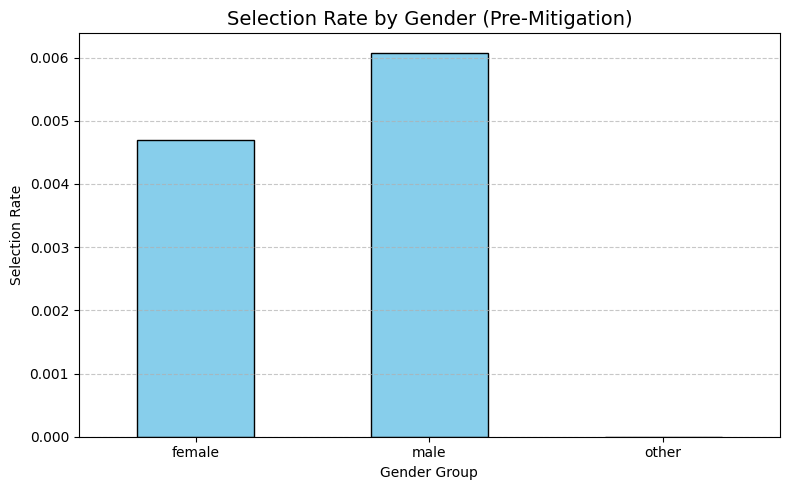

In [28]:
# Plot
selection_rates = metric_frame.by_group
plt.figure(figsize=(8, 5))
selection_rates.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Selection Rate by Gender (Pre-Mitigation)", fontsize=14)
plt.ylabel("Selection Rate")
plt.xlabel("Gender Group")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
#Compute demographic_parity_difference and ratio separately
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio

dp_diff = demographic_parity_difference(
    y_true=full_tracks_cbf['label'],
    y_pred=full_tracks_cbf['label'],
    sensitive_features=full_tracks_cbf['gender_grouped']
)

dp_ratio = demographic_parity_ratio(
    y_true=full_tracks_cbf['label'],
    y_pred=full_tracks_cbf['label'],
    sensitive_features=full_tracks_cbf['gender_grouped']
)

print(f"\nDemographic Parity Difference: {dp_diff:.3f}")
print(f"Demographic Parity Ratio: {dp_ratio:.3f}")


Demographic Parity Difference: 0.006
Demographic Parity Ratio: 0.000


In [30]:
from fairlearn.metrics import MetricFrame, selection_rate
import itertools
import pandas as pd

# Use MetricFrame to compute selection rates per group
metric_frame = MetricFrame(
    metrics=selection_rate,
    y_true=full_tracks_cbf['label'],
    y_pred=full_tracks_cbf['label'],
    sensitive_features=full_tracks_cbf['gender_grouped']
)

selection_rates = metric_frame.by_group  # Series with selection rate per gender group

# Compute all pairwise DPDs
dpd_values = []
groups = selection_rates.index.tolist()

for g1, g2 in itertools.combinations(groups, 2):
    diff = abs(selection_rates[g1] - selection_rates[g2])
    dpd_values.append({'Group 1': g1, 'Group 2': g2, 'DPD': round(diff, 6)})

# Display as DataFrame
dpd_df = pd.DataFrame(dpd_values).sort_values(by='DPD', ascending=False)
print(dpd_df)

  Group 1 Group 2       DPD
2    male   other  0.006079
1  female   other  0.004689
0  female    male  0.001390


### Fairness Evaluation (Pre-Mitigation): Selection Rate & Demographic Parity

#### Selection Rate by Gender Group

| Gender Group | Selection Rate |
|--------------|----------------|
| Female       | 0.0047         |
| Male         | 0.0061         |
| Other        | 0.0000         |

- **Male artists** were selected at the highest rate (~0.61%).
- **Female artists** were selected slightly less (~0.47%).
- **Artists in the 'Other' gender group** were **never** selected (0.00%).

This suggests an **exclusion** of nonbinary, gender-neutral, or unclassified artists by the content-based recommender.

---

#### Demographic Parity Metrics

- **Demographic Parity Difference**: `0.006`
- **Demographic Parity Ratio**: `0.000`

**Interpretation:**
- The **parity difference** indicates the absolute difference between the highest and lowest group selection rates (here: ~0.006 = 0.61% - 0.00%).
- A **parity ratio of 0.000** highlights a critical fairness issue: **one or more groups received no recommendations at all**, which violates demographic parity expectations.

---

#### Pairwise Demographic Parity Differences

| Group 1 | Group 2 | DPD      |
|---------|---------|----------|
| Male    | Other   | 0.00608  |
| Female  | Other   | 0.00469  |
| Female  | Male    | 0.00139  |

**Interpretation:**

- The largest disparity is between male and other, confirming the earlier overall DPD of 0.006.
- The female–other gap (0.0047) is also substantial, meaning artists from the 'other' group were underrepresented regardless of seed gender.
- The female–male gap (0.0014) is the smallest, indicating that the system is slightly biased toward male artists but the disparity is minor between binary genders.

--- 
#### Key Takeaways

- While the numerical gap between male and female artists is small, the **complete exclusion of the 'Other' group** is a serious red flag. This reflects structural underrepresentation.
- Even a "neutral" recommender can **amplify historical or dataset-inherited imbalances** if no mitigation strategy is applied.

➡️ These results provide strong motivation for fairness-aware interventions such as constraint-based modeling, or representation balancing.


## Bias Mitigation

In [31]:
# Copy core data
df = full_tracks_cbf[['label', 'gender_grouped']].dropna().copy()

# Optional: merge minor gender categories into 'other' (if not already done)
df['gender_grouped'] = df['gender_grouped'].replace({
    'nonbinary': 'other',
    'agender': 'other',
    'genderfluid': 'other',
    'trans woman': 'other',
    'neutral sex': 'other'
})

# Separate positives and negatives
df_pos = df[df['label'] == 1]
df_neg = df[df['label'] == 0]

# Choose how many negatives to sample per group
neg_target_counts = {
    'female': 20,
    'male': 100,
    'other': 20
}

# Sample negatives with fallback to all available if too few
df_neg_sampled = pd.concat([
    df_neg[df_neg['gender_grouped'] == group].sample(
        n=min(len(df_neg[df_neg['gender_grouped'] == group]), target),
        random_state=42,
        replace=False
    )
    for group, target in neg_target_counts.items()
])

# Combine and shuffle
df_balanced = pd.concat([df_pos, df_neg_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

In [32]:
# Merge with metadata to get text_features and reuse previous tf-idf pipeline
df_balanced = df_balanced.merge(
    track_df[['Track', 'Artist', 'Album', 'text_features']],
    left_index=True, right_index=True, how='left'
)

from sklearn.feature_extraction.text import TfidfVectorizer

# Generate new TF-IDF matrix based on balanced set
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_balanced['text_features'].fillna(''))

y = df_balanced['label'].astype(int)
A = df_balanced['gender_grouped']

In [33]:
from sklearn.linear_model import LogisticRegression
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

estimator = LogisticRegression(solver='liblinear')
mitigator = ExponentiatedGradient(
    estimator,
    constraints=DemographicParity(),
    sample_weight_name="sample_weight"
)

mitigator.fit(X_train, y_train, sensitive_features=A_train)
y_pred_mitigated = mitigator.predict(X_test)

In [34]:
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    demographic_parity_difference,
    demographic_parity_ratio
)

mf_mitigated = MetricFrame(
    metrics=selection_rate,
    y_true=y_test,
    y_pred=y_pred_mitigated,
    sensitive_features=A_test
)

print("Selection rate by gender (post-mitigation):")
print(mf_mitigated.by_group)

print(f"\nDP Difference: {demographic_parity_difference(y_test, y_pred_mitigated, sensitive_features=A_test):.4f}")
print(f"DP Ratio: {demographic_parity_ratio(y_test, y_pred_mitigated, sensitive_features=A_test):.4f}")


Selection rate by gender (post-mitigation):
gender_grouped
female    0.000000
male      0.001558
other     0.000000
Name: selection_rate, dtype: float64

DP Difference: 0.0016
DP Ratio: 0.0000


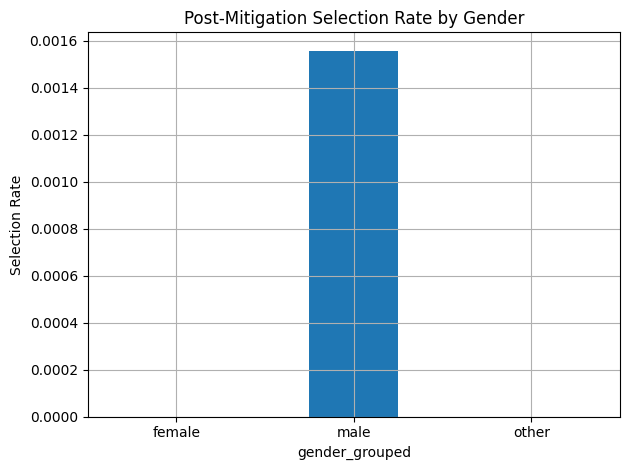

In [35]:
import matplotlib.pyplot as plt

mf_mitigated.by_group.plot(kind='bar', title='Post-Mitigation Selection Rate by Gender', ylabel='Selection Rate')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
from fairlearn.metrics import MetricFrame, selection_rate

mf_cbf = MetricFrame(
    metrics=selection_rate,
    y_true=full_tracks_cbf['label'],
    y_pred=full_tracks_cbf['label'],
    sensitive_features=full_tracks_cbf['gender_grouped']
)

In [37]:
# Rename series for display
pre_rates = mf_cbf.by_group.rename("Pre-Mitigation")
post_rates = mf_mitigated.by_group.rename("Post-Mitigation")

# Combine into one DataFrame
comparison_df = pd.concat([pre_rates, post_rates], axis=1)

# Display
print(comparison_df)

                Pre-Mitigation  Post-Mitigation
gender_grouped                                 
female                0.004689         0.000000
male                  0.006079         0.001558
other                 0.000000         0.000000


### Fairness Evaluation: Pre- vs. Post-Mitigation (Content-Based Recommender)

This section interprets the impact of applying **Exponentiated Gradient bias mitigation** using the **Demographic Parity** constraint on a content-based recommender trained with a balanced dataset.

---

#### 1. Selection Rates by Gender

| Gender Group | Pre-Mitigation | Post-Mitigation |
|--------------|----------------|-----------------|
| Female       | 0.0047         | 0.0000          |
| Male         | 0.0061         | 0.0016          |
| Other        | 0.0000         | 0.0000          |

- **Pre-Mitigation:** The model recommended male artists more often (0.61%) than female (0.47%), with **no recommendations at all** for the 'other' gender group.
- **Post-Mitigation:** Surprisingly, **only male artists were recommended**, though at a lower rate (0.16%). Female and 'other' groups received **no recommendations**.

---

#### 2. Demographic Parity Metrics

| Metric                        | Value (Post-Mitigation) |
|------------------------------|--------------------------|
| Demographic Parity Difference| 0.0016                   |
| Demographic Parity Ratio     | 0.0000                   |

- The **DP Difference** has technically **decreased** (from 0.0060 to 0.0016), suggesting a more equal spread in theory.
- However, the **DP Ratio** remains **0.000**, due to **zero selection for two of the three groups**.

This shows the paradox that **numeric fairness metrics can improve** even when **actual group representation worsens** or disappears entirely.

---

#### 3. Interpretation of Mitigation Behavior

The mitigation method **succeeded in minimizing selection disparity numerically**, but **failed in producing meaningful or fair recommendations** for all groups:

- **Male group dominance** remains — though attenuated.
- **Female and 'Other' groups are now fully excluded**, indicating an overcorrection or failure to learn from these groups.
- This outcome highlights that **constraints alone are not sufficient** if the model lacks:
  - Representative features per group,
  - Sufficient training signals (even after balancing),
  - Or if the logistic model is too simplistic to differentiate subtle patterns.

---

#### 4. Key Takeaways

- **Fairness constraints must be paired with robust data engineering**, including adequate group representation in both features and labels.
- **Demographic parity as a constraint may conflict with recommendation relevance**, especially if underlying patterns differ strongly by group.
- This result underscores the need for:
  - More expressive models (e.g., neural recommenders),
  - Alternative fairness metrics (e.g., Equal Opportunity),
  - Or hybrid strategies (e.g., post-processing ranking fairness, re-ranking, or exposure-aware models).

---